<a href="https://colab.research.google.com/github/Erdem96isik/Machine_learning/blob/master/DecionTree-tf_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# developers.google.com/machine-learning/decision-forests/

In [1]:
!pip install tensorflow_decision_forests

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 75.9 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import tensorflow_decision_forests as tfdf

This is a classification problem—the goal is to predict the species of penguin based on data in the Palmer's Penguins dataset.

Let’s meet the penguins.

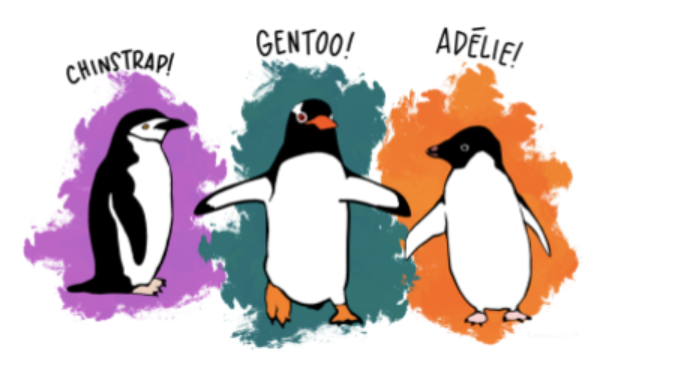

In [3]:
path = "https://storage.googleapis.com/download.tensorflow.org/data/palmer_penguins/penguins.csv"
pandas_dataset = pd.read_csv(path)

# Display the first 3 examples.
pandas_dataset.head(3)

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007


To simplify interpretability, the following code cell manually converts the penguin species into integer labels:

In [4]:
blabel = "species"

classes = list(pandas_dataset[label].unique())

In [6]:
print(f"Label classes: {classes}")
# >> Label classes: ['Adelie', 'Gentoo', 'Chinstrap']

pandas_dataset[label] = pandas_dataset[label].map(classes.index)

Label classes: ['Adelie', 'Gentoo', 'Chinstrap']


The following code cell splits the dataset into a training set and testing set:

In [7]:
np.random.seed(1)
# Use the ~10% of the examples as the testing set
# and the remaining ~90% of the examples as the training set.
test_indices = np.random.rand(len(pandas_dataset)) < 0.1
pandas_train_dataset = pandas_dataset[~test_indices]
pandas_test_dataset = pandas_dataset[test_indices]

print("Training examples: ", len(pandas_train_dataset))
# >> Training examples: 309

print("Testing examples: ", len(pandas_test_dataset))
# >> Testing examples: 35

Training examples:  309
Testing examples:  35


# **[Training a model with default hyperparameters](https://developers.google.com/machine-learning/decision-forests/practice#training_a_model_with_default_hyperparameters)**

We can train our first CART (Classification and Regression Trees) model without specifying any hyperparameters. That's because the tfdf.keras.CartModel function provides good default hyperparameter values. You will learn more about how this type of model works later in the course.

In [8]:
tf_train_dataset = tfdf.keras.pd_dataframe_to_tf_dataset(pandas_train_dataset, label=label)
model = tfdf.keras.CartModel()
model.fit(tf_train_dataset)

Use /tmp/tmp1lnw83kw as temporary training directory
Reading training dataset...
Training dataset read in 0:00:06.627354. Found 309 examples.
Training model...
Model trained in 0:00:00.046007
Compiling model...


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model compiled.


The preceding call to tfdf.keras.CartModel did not specify columns to use as input features. Therefore, every column in the training set is used. The call also did not specify the semantics (for example, numerical, categorical, text) of the input features. Therefore, tfdf.keras.CartModel will automatically infer the semantics.

Call tfdf.model_plotter.plot_model_in_colab to display the resulting decision tree:

In [9]:
tfdf.model_plotter.plot_model_in_colab(model, max_depth=10)

In [10]:
model.compile("accuracy")
print("Train evaluation: ", model.evaluate(tf_train_dataset, return_dict=True))
# >> Train evaluation:  {'loss': 0.0, 'accuracy': 0.96116}

tf_test_dataset = tfdf.keras.pd_dataframe_to_tf_dataset(pandas_test_dataset, label=label)
print("Test evaluation: ", model.evaluate(tf_test_dataset, return_dict=True))
# >> Test evaluation:  {'loss': 0.0, 'accuracy': 0.97142}

1/1 [==============================] - 1s 706ms/step - loss: 0.0000e+00 - accuracy: 0.9709
Train evaluation:  {'loss': 0.0, 'accuracy': 0.9708737730979919}
1/1 [==============================] - 0s 137ms/step - loss: 0.0000e+00 - accuracy: 0.9714
Test evaluation:  {'loss': 0.0, 'accuracy': 0.9714285731315613}


In [11]:
!pip install keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 6.6 MB/s eta 0:00:00


In [12]:
import keras_tuner as kt

def build_model(hp):
  model = tfdf.keras.CartModel(
      min_examples=hp.Choice("min_examples",
          # Try four possible values for "min_examples" hyperparameter.
          # min_examples=10 would limit the growth of the decision tree,
          # while min_examples=1 would lead to deeper decision trees.
         [1, 2, 5, 10]),
      validation_ratio=hp.Choice("validation_ratio",
         # Three possible values for the "validation_ratio" hyperparameter.
         [0.0, 0.05, 0.10]),
      )
  model.compile("accuracy")
  return model

tuner = kt.RandomSearch(
    build_model,
    objective="val_accuracy",
    max_trials=10,
    directory="/tmp/tuner",
    project_name="tune_cart")

tuner.search(x=tf_train_dataset, validation_data=tf_test_dataset)
best_model = tuner.get_best_models()[0]

print("Best hyperparameters: ", tuner.get_best_hyperparameters()[0].values)
# >> Best hyperparameters:  {'min_examples': 2, 'validation_ratio': 0.0}

Trial 10 Complete [00h 00m 01s]
val_accuracy: 0.9714285731315613

Best val_accuracy So Far: 0.9714285731315613
Total elapsed time: 00h 00m 12s
Use /tmp/tmp6spswplm as temporary training directory
Best hyperparameters:  {'min_examples': 2, 'validation_ratio': 0.1}


In [13]:
model = tfdf.keras.CartModel(min_examples=2, validation_ratio=0.0)
model.fit(tf_train_dataset)

model.compile("accuracy")
print("Test evaluation: ", model.evaluate(tf_test_dataset, return_dict=True))
# >> Test evaluation:  {'loss': 0.0, 'accuracy': 1.0}

Use /tmp/tmp5s8dpica as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.426666. Found 309 examples.
Training model...
Model trained in 0:00:00.034596
Compiling model...
Model compiled.
1/1 [==============================] - 0s 104ms/step - loss: 0.0000e+00 - accuracy: 0.9714
Test evaluation:  {'loss': 0.0, 'accuracy': 0.9714285731315613}


In [14]:
tfdf.model_plotter.plot_model_in_colab(model, max_depth=10)